# Training MLP to predict survival

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [132]:
import os
import plotly
from plotly import tools
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from myutils import efron_estimator_tf, my_mse, plot_history, sub_plot_history2

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2, l1
from keras.models import Model
from keras.callbacks import TensorBoard

from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split

## 1. Import and prepare the data:

In [74]:
data = np.load('synthetic_imgs/non-monotonic-risk.npz')

Check example images. Here we take 5 random images from the low-risk end (1st row) and 5 from the high-risk end (2nd row).

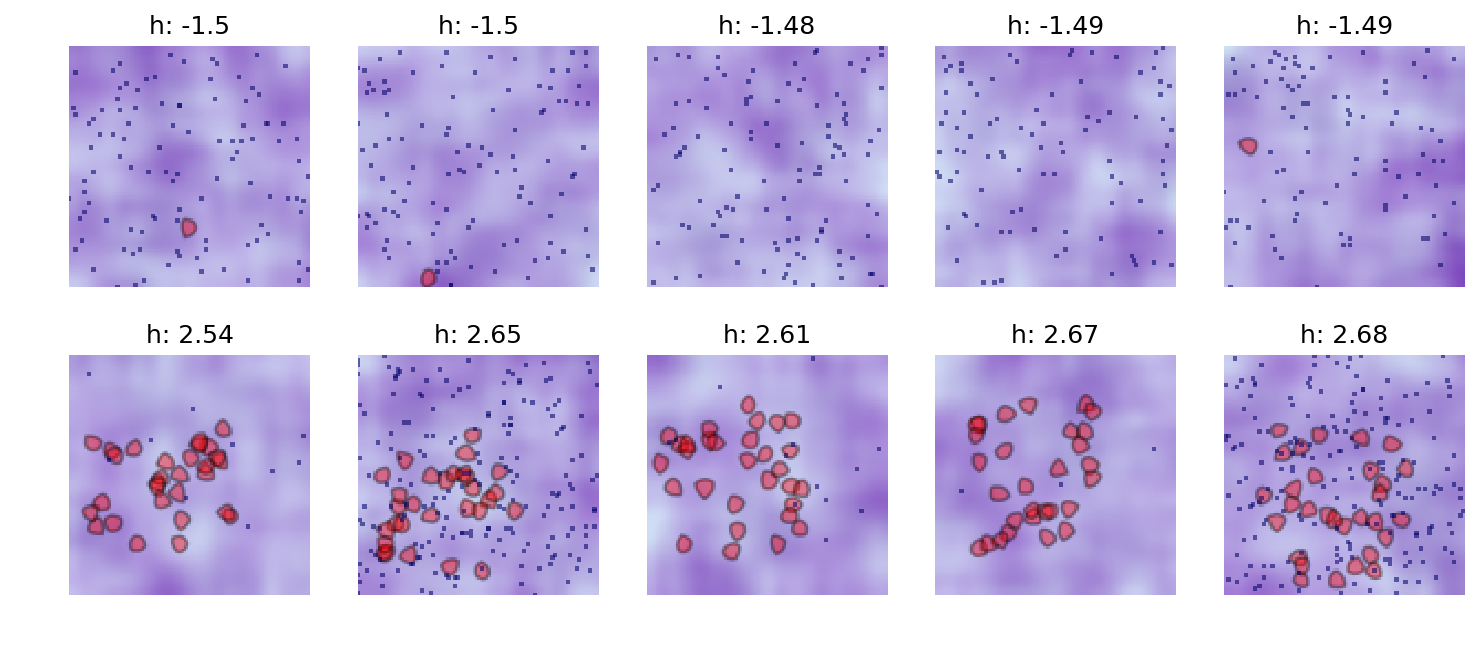

In [94]:
sort_idx = np.argsort(data['Ys'][:,0])
fig = plt.figure(figsize=(12, 5), dpi=150)
for pp in range(0,5):
    idx = sort_idx[pp+np.random.choice(50,1)[0]]
    plt.subplot(2,5,pp+1)
    plt.imshow( data['Xs'][idx] )
    plt.title('h: %s' % str(np.round( data['Ys'][idx,0], 2 )))
    plt.axis('off')
for pp in range(0,5):
    idx = sort_idx[-(pp+np.random.choice(50,1)[0]+1)]
    plt.subplot(2,5,5+pp+1)
    plt.imshow( data['Xs'][idx] )
    plt.title('h: %s' % str(np.round( data['Ys'][idx,0], 2 )))
    plt.axis('off')
plt.show()

Train / Test splitting:

In [97]:
train_idx, test_idx = train_test_split(range(data['Xs'].shape[0]), test_size=1500, random_state=777)

print("Train split: %d; Test split: %d." % (len(train_idx), len(test_idx)))

Train split: 5500; Test split: 1500.


## 2. Train Conv Nets

We age going to train different models ... The network is exactly the same for all the three models except for the last laler and the loss.

In [114]:
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization

In [ ]:
inputs = Input(shape=(109,109,3,), name='InputImg')

x = Conv2D(12, (3, 3))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(12, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(12, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(96)(x)
x = BatchNormalization()(x)

#test_m = Model(inputs, x)
#test_m.summary()

### 2.1. Binary Cross-Entropy

In [18]:
preds = Dense(1, activation='sigmoid')(x)
crossentropy_model = Model(inputs=inputs, outputs=preds)

crossentropy_model.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')

In [19]:
history = crossentropy_model.fit(
                x   = data['Xs'][train_idx],
                y   = data['bin_t2'][train_idx],
                validation_split  = 0.35,
                batch_size        = 200,
                epochs            = 350,
                verbose           = 0)

train_preds = np.squeeze(crossentropy_model.predict(data['Xs'][train_idx]))

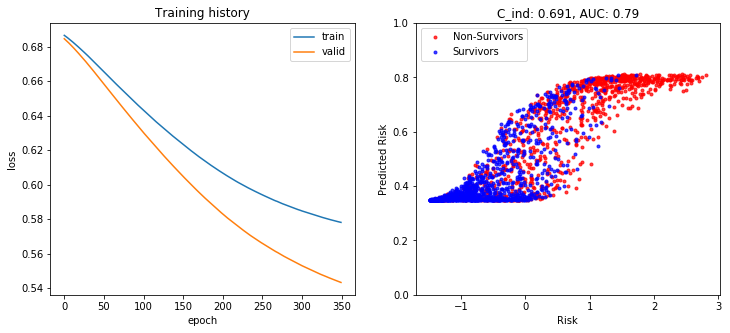

In [20]:
sub_plot_history(history, train_preds, data, train_idx, h_type=2, y_lim=(0,1))

### 2.2. Least-MSE-Regression

In [141]:
preds = Dense(1, activation='linear')(x)
mse_model = Model(inputs=inputs, outputs=preds)

mse_model.compile(optimizer = 'adadelta', loss = 'mse')

In [142]:
tmp_idx = train_idx[0:500]

In [143]:
history = mse_model.fit(
                x   = data['Xs'][tmp_idx],
                y   = data['Ys'][tmp_idx,0],
                validation_split  = 0.33,
                batch_size        = 20,
                epochs            = 5,
                verbose           = 1 )

train_preds = np.squeeze(mse_model.predict(data['Xs'][tmp_idx]))

Train on 325 samples, validate on 175 samples
Epoch 1/5
325/325 [==============================] - 4s 14ms/step - loss: 1.6076 - val_loss: 1.0925
Epoch 2/5
325/325 [==============================] - 3s 10ms/step - loss: 0.6651 - val_loss: 1.1564
Epoch 3/5
325/325 [==============================] - 3s 10ms/step - loss: 0.3761 - val_loss: 1.3048
Epoch 4/5
325/325 [==============================] - 3s 10ms/step - loss: 0.2623 - val_loss: 1.2472
Epoch 5/5
325/325 [==============================] - 3s 10ms/step - loss: 0.1898 - val_loss: 1.3831


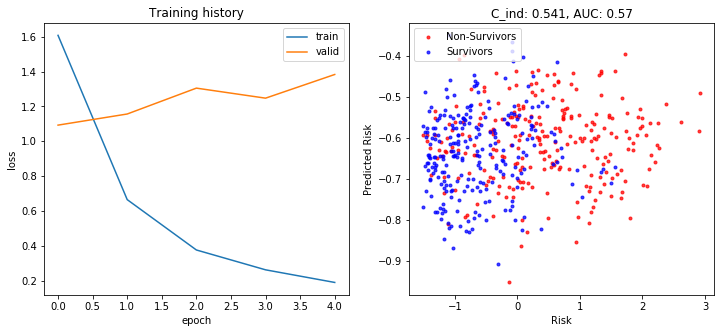

In [144]:
sub_plot_history2(history, train_preds, data, tmp_idx)

### 2.3. Efron Survival Regression

In [27]:
preds = Dense(1, activation='linear')(x)
efron_model = Model(inputs=inputs, outputs=preds)

efron_model.compile(optimizer = 'adadelta', loss = efron_estimator_tf)

In [ ]:
history = efron_model.fit(
                x   = data['Xs'][train_idx],
                y   = np.hstack((np.zeros_like(data['t1']),data['t2'],data['e2']))[train_idx],
                validation_split  = 0.35,
                batch_size        = 200,
                epochs            = 350,
                verbose           = 0)

train_preds = np.squeeze(efron_model.predict(data['Xs'][train_idx]))

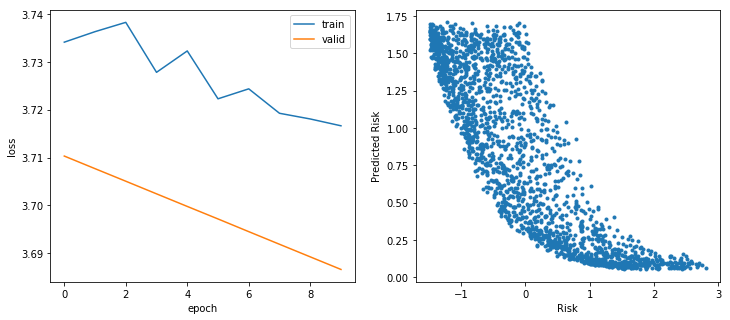

In [439]:
sub_plot_history(history, train_preds, data, train_idx, h_type=2)

## 3. Evaluate

...